# 유전체 정보 품종 분류 AI 경진대회 _ 정리본

## 패키지 다운로드

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from tensorflow.keras.layers import Dense, Dropout, Embedding, concatenate, Flatten, Input
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from BorutaShap import BorutaShap

## 데이터 전처리

In [5]:

path = "C:/Users/32197453/Desktop/비교과/공모전/유전체 정보 품종 분류 AI 경진대회/"
train = pd.read_csv(path + "train.csv").set_index('id')
test_x2 = pd.read_csv(path + "test.csv").set_index('id')
test_y2 = pd.read_csv(path + "sample_submission.csv").set_index('id')
train_x2 = train.drop('class', axis=1)
train_y2 = train['class']

class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]

snp_data = []
for col in snp_col:
    snp_data += list(train_x2[col].values)

train_y2 = class_le.fit_transform(train_y2)
snp_le.fit(snp_data)

for col in train_x2.columns:
    if col in snp_col:
        train_x2[col] = snp_le.transform(train_x2[col])
        test_x2[col] = snp_le.transform(test_x2[col])

X_train2 = train_x2
y_train2 = train_y2
X_test2 = test_x2
y_test2 = test_y2

## XGBoost

In [6]:
xgb_param = {
    'n_estimators' : [100, 300, 500, 700, 1000],
    'learning_rate' : [0.01, 0.25, 0.05, 0.1, 0.2, 0.3],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14, 16],
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight' : [1, 10, 20, 30, 40, 50]
}
xgb_grid2 = GridSearchCV(estimator = XGBClassifier(), param_grid= xgb_param, n_jobs=-1, cv=3, refit=True)
xgb_grid2.fit(X_train2, y_train2)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.25, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
                         'min_child_weight': [1, 10, 20, 30, 40, 50],
                         'n_estimators': [100, 300, 500, 700, 1000],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]})

In [7]:
print("최고 평균 정확도 : {0:.6f}".format(xgb_grid2.best_score_))
print("최고의 파라미터 : ", xgb_grid2.best_params_)

최고 평균 정확도 : 0.954284
최고의 파라미터 :  {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}


In [8]:
model_xgb2 = xgb_grid2.best_estimator_
y_pred_xgb2 = model_xgb2.predict(X_test2)
y_pred_xgb2

array([0, 1, 2, 1, 0, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1],
      dtype=int64)

In [9]:
# #결과 파일 제출
# submit = test_y
# submit['class'] = class_le.inverse_transform(y_pred_xgb2)
# submit.to_csv(path + 'submit_xgb7.csv')

DACON 제출 후 Macro F1 Score : 0.971917

#### 변수선택

In [10]:
#BorutaShap T-검정을 통해서 변수의 중요도 나열
model_for_sel = model_xgb2
feature_selector = BorutaShap(model=model_for_sel, importance_measure='shap', classification=True)
feature_selector.fit(X=X_train2, y=y_train2, n_trials=100, sample=False,
            	     train_or_test = 'train', verbose=0)

  0%|          | 0/100 [00:00<?, ?it/s]

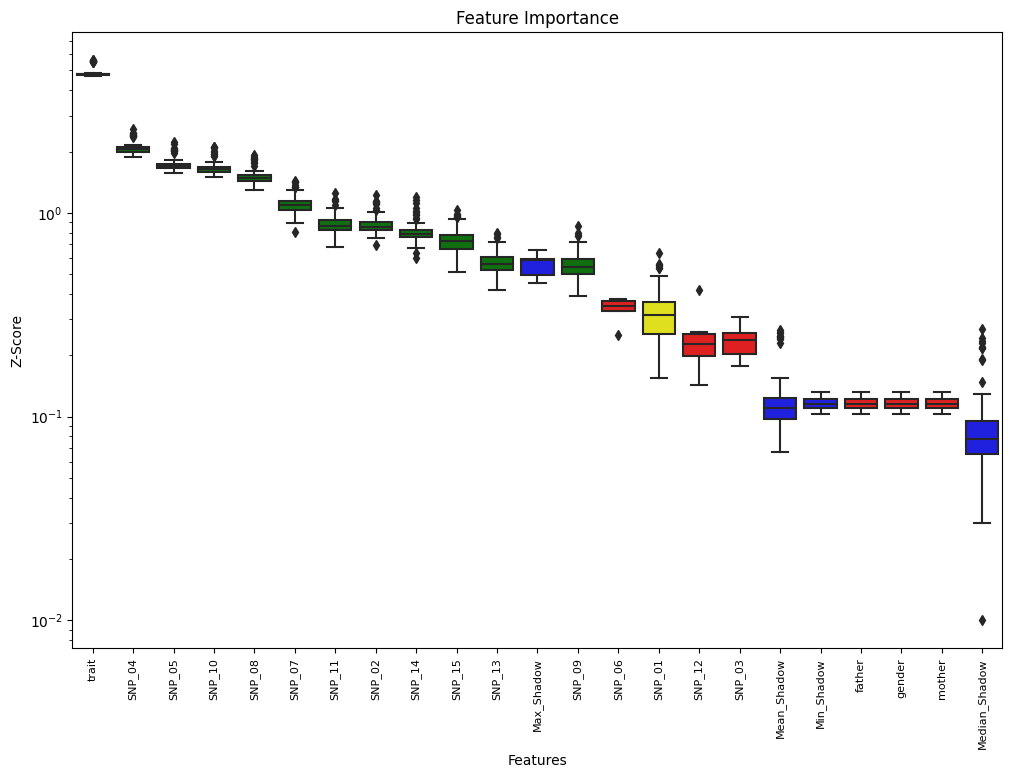

In [11]:
# Returns Boxplot of features
feature_selector.plot(which_features='all')

#### father, mother, gender 제거 + SNP_03 제거 모델

In [12]:
X_train3 = train_x2.drop(['father', 'mother', 'gender', 'SNP_03'], axis=1)
X_test3 = X_test2.drop(['father', 'mother', 'gender', 'SNP_03'], axis=1)

In [13]:
xgb_param = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'learning_rate' : [0.01, 0.25, 0.05, 0.1, 0.2, 0.3, 0.5],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
}
xgb_grid3 = GridSearchCV(estimator = XGBClassifier(), param_grid= xgb_param, n_jobs=-1, cv=3, refit=True)
xgb_grid3.fit(X_train3, y_train2)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.25, 0.05, 0.1, 0.2, 0.3,
                                           0.5],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [14]:
print("최고 평균 정확도 : {0:.6f}".format(xgb_grid3.best_score_))
print("최고의 파라미터 : ", xgb_grid3.best_params_)

최고 평균 정확도 : 0.946665
최고의 파라미터 :  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 100}


In [15]:
model_xgb3 = xgb_grid3.best_estimator_
y_pred_xgb3 = model_xgb3.predict(X_test3)
y_pred_xgb3

array([0, 1, 2, 1, 0, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1],
      dtype=int64)

In [16]:
# #결과파일 출력
# submit = test_y
# submit['class'] = class_le.inverse_transform(y_pred_xgb3)
# submit.to_csv(path + 'submit_xgb3.csv')

DACON 제출 후 Macro F1 Score : 0.971917

#### father, mother, gender 제거 + SNP_03, SNP_12, SNP_06 제거 모델

In [17]:
X_train4 = train_x2.drop(['father', 'mother', 'gender', 'SNP_03', 'SNP_12', 'SNP_06'], axis=1)
X_test4 = X_test2.drop(['father', 'mother', 'gender', 'SNP_03', 'SNP_12', 'SNP_06'], axis=1)

In [18]:
xgb_param = {
    'n_estimators' : [100, 300, 500, 700, 1000],
    'learning_rate' : [0.01, 0.25, 0.05, 0.1, 0.2, 0.3],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14, 16],
    'min_child_samples' : [20, 30, 40, 50, 60],
    'boosting_type' : ['gbdt', 'rt', 'dart']
}
xgb_grid4 = GridSearchCV(estimator = XGBClassifier(), param_grid= xgb_param, n_jobs=-1, cv=3, refit=True)
xgb_grid4.fit(X_train4, y_train2)

[01:32:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boosting_type", "min_child_samples" } are not used.



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'rt', 'dart'],
                         'learning_rate': [0.01, 0.25, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
                         'min_child_samples': [20, 30, 40, 50, 60],
                         'n_estimators': [100, 300, 500, 700, 1000]})

In [19]:
print("최고 평균 정확도 : {0:.6f}".format(xgb_grid4.best_score_))
print("최고의 파라미터 : ", xgb_grid4.best_params_)

최고 평균 정확도 : 0.958029
최고의 파라미터 :  {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 2, 'min_child_samples': 20, 'n_estimators': 300}


In [20]:
model_xgb4 = xgb_grid4.best_estimator_
y_pred_xgb4 = model_xgb4.predict(X_test4)
y_pred_xgb4

array([0, 1, 2, 1, 0, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0,
       1, 1, 1, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1],
      dtype=int64)

In [21]:
# #결과파일 출력
# submit = test_y
# submit['class'] = class_le.inverse_transform(y_pred_xgb4)
# submit.to_csv(path + 'submit_xgb4.csv')

DACON 제출 후 Macro F1 Score : 0.971917

## LGBM

#### father, mother, gender 제거 + SNP_03, SNP_12, SNP_06 제거 모델

In [22]:
lgbm_param = {
    'n_estimators' : [100, 300, 500, 700, 1000],
    'learning_rate' : [0.01, 0.25, 0.05, 0.1, 0.2, 0.3],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14, 16],
    'min_child_samples' : [20, 30, 40, 50, 60],
    'boosting_type' : ['gbdt', 'rt', 'dart']
}
lgbm_grid1 = GridSearchCV(estimator = LGBMClassifier(), param_grid= lgbm_param, n_jobs=-1, cv=3, refit=True)
lgbm_grid1.fit(X_train4, y_train2)

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'rt', 'dart'],
                         'learning_rate': [0.01, 0.25, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
                         'min_child_samples': [20, 30, 40, 50, 60],
                         'n_estimators': [100, 300, 500, 700, 1000]})

In [23]:
print("최고 평균 정확도 : {0:.6f}".format(lgbm_grid1.best_score_))
print("최고의 파라미터 : ", lgbm_grid1.best_params_)

최고 평균 정확도 : 0.958029
최고의 파라미터 :  {'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 20, 'n_estimators': 100}


In [24]:
model_lgbm1 = lgbm_grid1.best_estimator_
y_pred_lgbm1 = model_lgbm1.predict(X_test4)
y_pred_lgbm1

array([0, 1, 2, 1, 0, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0,
       1, 1, 1, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1])

In [25]:
# #결과파일 출력
# submit = test_y
# submit['class'] = class_le.inverse_transform(y_pred_lgbm1)
# submit.to_csv(path + 'submit_lgbm1.csv')

DACON 제출 후 Macro F1 Score : 0.962237

## Neural Network

In [26]:
from keras import Sequential, Model
from keras.layers import Dense, Dropout

#### 1

In [27]:
def define_model():
    model = Sequential()
    model.add(Dense(32, input_dim = 19, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

In [28]:
model = define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                640       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 1,219
Trainable params: 1,219
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [30]:
model.fit(X_train2, pd.get_dummies(y_train2), epochs=100, batch_size=100)

Epoch 1/100
3/3 [==============================] - 1s 4ms/step - loss: 1.5575 - accuracy: 0.3779
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 1.3111 - accuracy: 0.3931
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 1.1125 - accuracy: 0.4160
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.9700 - accuracy: 0.5344
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.8717 - accuracy: 0.5916
Epoch 6/100
3/3 [==============================] - 0s 2ms/step - loss: 0.7994 - accuracy: 0.5992
Epoch 7/100
3/3 [==============================] - 0s 2ms/step - loss: 0.7370 - accuracy: 0.6145
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.6565
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6832
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6080 - accuracy: 0.7099
Epoch 11/100
3/3 [===========

In [31]:
y_pred_NN = model.predict(X_test2)

6/6 [==============================] - 0s 1ms/step


In [32]:
y_submit_NN1 = tf.argmax(y_pred_NN, axis=1)

In [33]:
# submit = test_y
# submit['class'] = class_le.inverse_transform(y_submit_NN1)
# submit.to_csv(path + 'submit_NN1.csv')

DACON 제출 후 Macro F1 Score : 0.981428

#### 2 _ Dropout

In [34]:
def define_model():
    model = Sequential()
    model.add(Dense(128, input_dim = 19, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

In [35]:
model = define_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               2560      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [37]:
model.fit(X_train2, pd.get_dummies(y_train2), epochs=100, batch_size=100)

Epoch 1/100
3/3 [==============================] - 1s 4ms/step - loss: 1.8405 - accuracy: 0.2519
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 1.1996 - accuracy: 0.3740
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.8691 - accuracy: 0.5840
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7630 - accuracy: 0.6412
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5748 - accuracy: 0.7519
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5263 - accuracy: 0.7672
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4771 - accuracy: 0.7824
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4258 - accuracy: 0.8168
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4059 - accuracy: 0.8359
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.3299 - accuracy: 0.8855
Epoch 11/100
3/3 [===========

In [38]:
y_pred_NN = model.predict(X_test2)

6/6 [==============================] - 0s 1ms/step


In [39]:
y_submit_NN4 = tf.argmax(y_pred_NN, axis=1)

In [40]:
# submit = test_y
# submit['class'] = class_le.inverse_transform(y_submit_NN4)
# submit.to_csv(path + 'submit_NN4.csv')

DACON 제출 후 Macro F1 Score : 0.981428

#### 3 - Dropout + father, mother, gender 제거

In [41]:
X_train_SNP = train_x2.drop(['father', 'mother', 'gender'], axis=1)
X_test_SNP = X_test2.drop(['father', 'mother', 'gender'], axis=1)

In [42]:
def define_model():
    model = Sequential()
    model.add(Dense(128, input_dim = 16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

In [43]:
model = define_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               2176      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,627
Trainable params: 10,627
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [45]:
model.fit(X_train_SNP, pd.get_dummies(y_train2), epochs=100, batch_size=100)

Epoch 1/100
3/3 [==============================] - 1s 3ms/step - loss: 1.9054 - accuracy: 0.2748
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2232 - accuracy: 0.4046
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9113 - accuracy: 0.5840
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7931 - accuracy: 0.6527
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.7023
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.7328
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5137 - accuracy: 0.7672
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4002 - accuracy: 0.8282
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4007 - accuracy: 0.8435
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.8664
Epoch 11/100
3/3 [===========

In [46]:
y_pred_NN = model.predict(X_test_SNP)

6/6 [==============================] - 0s 1ms/step


In [47]:
y_submit_NN5 = tf.argmax(y_pred_NN, axis=1)

In [48]:
# submit = test_y
# submit['class'] = class_le.inverse_transform(y_submit_NN5)
# submit.to_csv(path + 'submit_NN5.csv')

DACON 제출 후 Macro F1 Score : 0.981428